In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# 1. Paths and Read-In (segmentation mask based)

In [2]:
# Corresponding videos
vid_path = "../data/videos/egocentric/birdbath/ori_videos/"
vid_filename = "2024_0330_122058_107_trimmed_ts6-te120.mp4"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = get_video_properties(vid_path, vid_filename)
print(vid_props) # ["filename", "fps", "num_frames", "width", "height"]

# Scale D-high
pixel_per_real_width = .61
mpp = 1.65  # microns_per_pixel
print("D high - FHD, pixel_per_real_width = ", pixel_per_real_width)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(0, num_frames, 2) # resample to 30 fps
img_save_dir = f"../data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), img_save_dir, export_frames) if EXPORT_FRAMES else None

(60, 5647, 1920, 1080)
D high - FHD, pixel_per_real_width =  0.61


### Read in matching images-segmasks

In [3]:
# IMAGES
img_filenames = sorted([fn for fn in os.listdir(img_save_dir) if fn.endswith("jpg")])
img_filepaths = [os.path.join(img_save_dir, fn) for fn in img_filenames]

# Downsampled according to every second image frame exported
img_indices = [ii.split("_")[-1].split(".jpg")[0] for ii in img_filenames]

# CREATE! mask filenames based every second image frame exported
masks_dir = f"../data/videos/egocentric/birdbath/seg_masks/{vid_filename.split('.')[0]}_masks/"
mask_filenames = [fn + ".png" for fn in img_indices]
mask_filepaths = [os.path.join(masks_dir, fn) for fn in mask_filenames]

# Get contours from masks
contour_list = get_contours_from_segmasks(mask_filepaths)

# Get contour stats
df_stats = get_contour_stats(contour_list, min_area=2200)

# Add infos to dataframe
df_stats["indices"] = [int(i) for i in img_indices]
df_stats[["img_fp", "mask_fp"]] = pd.DataFrame({'img_fp': img_filepaths, 'mask_fp': mask_filepaths})

# Check corresponding lengths
print(len(contour_list), len(mask_filepaths), len(df_stats))
print("centroid isNaN:", df_stats["centroid_x"].isna().sum())

2818 2818 2818
centroid isNaN: 17


In [4]:
# get rid of indices where segmask fails
df_stats["segmask_fails"] = False
segmask_fails = {0 : ["02956", "02986"], 1 : ["03108", "03354"], 2 : ["04052", "04108"]}  # crustacean

for start, end in segmask_fails.values():
    df_stats.loc[df_stats["indices"].between(int(start), int(end)), "segmask_fails"] = True

# Remove segmask rows for plotting
df_stats.loc[df_stats["segmask_fails"], df_stats.columns != "segmask_fails"] = np.nan

# Time plots

In [5]:
# Get frames and noralized perimeter
frames, perimeter = df_stats[["indices", "perimeter"]].values.T
time = frames / fps
nperimeter = perimeter / mpp

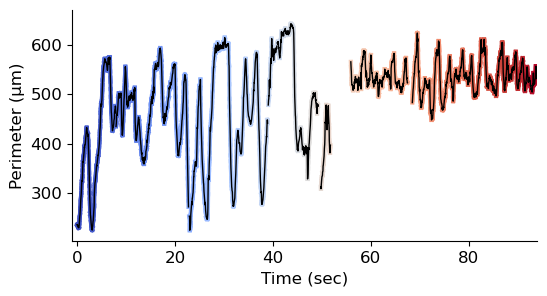

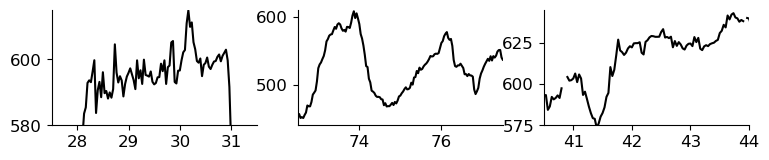

In [6]:
hindices = np.arange(0, len(df_stats))  # highlight
tc, _ = create_scalarmappable("coolwarm", hindices)

fig, ax = plt.subplots(figsize=(6,3))
plot_colorline(time[hindices], nperimeter[hindices], colors=tc, ax=ax, lw=3)
ax.plot(time, nperimeter, "-k", lw=1)
ax.plot([1780, 1852, 2064], [650,650,650], "oc")
ax.set(xlabel="Time (sec)", ylabel="Perimeter (µm)", xlim=(-1, 94));

ax_params = {0 : dict(xlim=(27.5, 31.5), ylim=(580, 615)),
             1 : dict(xlim=(72.5, 77.5), ylim=(440, 610)),
             2 : dict(xlim=(40.5, 44.), ylim=(575, 645))}

fig, ax = plt.subplots(1,3,figsize=(9,1.5))
for cax in ax: cax.plot(time, nperimeter, "-k", lw=1.5)
for k, params in ax_params.items(): ax[k].set(**params)

In [7]:
(1852-15)/fps, (2064+15)/fps

(30.616666666666667, 34.65)

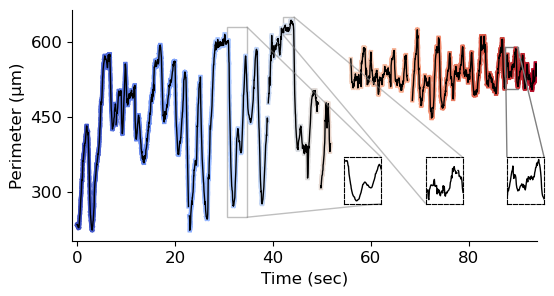

In [36]:
SAVE_FIGURES = False

fig, ax = plt.subplots(figsize=(6,3))
plot_colorline(time[hindices], nperimeter[hindices], colors=tc, ax=ax, lw=3)
ax.plot(time, nperimeter, "-k", lw=1)
ax.set(xlabel="Time (sec)", ylabel="Perimeter (µm)", xlim=(-1, 94), yticks=[300, 450, 600]);
#plot_bbox([(1852-15)/fps, (2064+15)/fps, 250, 625], c="gray", ax=ax)

# Inset 0
ax_inset0 = inset_axes(ax, width="20%", height="40%", loc='lower center',
                       bbox_to_anchor=(0.425, 0.125, 0.4, 0.5), bbox_transform=ax.transAxes)
ax_inset0.plot(time, nperimeter, "-k", lw=1)
ax_inset0.set(xlim=(30.6, 34.65), ylim=(250, 630))
ax_inset0.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
for spine in ax_inset0.spines.values():
        spine.set_visible(True)
        spine.set_linestyle('--')
mark_inset(ax, ax_inset0, loc1=1, loc2=4, fc="none", ec="gray", alpha=.5)

# Inset 1
ax_inset1 = inset_axes(ax, width="20%", height="40%", loc='lower center',
                       bbox_to_anchor=(0.6, 0.125, 0.4, 0.5), bbox_transform=ax.transAxes)
ax_inset1.plot(time, nperimeter, "-k", lw=1)
ax_inset1.set(xlim=(42, 44.25), ylim=(615, 650)) #  ax_inset1.set(xlim=(27.5, 31.5), ylim=(580, 630))
ax_inset1.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
for spine in ax_inset1.spines.values():
        spine.set_visible(True)
        spine.set_linestyle('--')
mark_inset(ax, ax_inset1, loc1=1, loc2=3, fc="none", ec="gray", alpha=.5)

# Inset 2
ax_inset2 = inset_axes(ax, width="20%", height="40%", loc='lower center',
                       bbox_to_anchor=(0.775, 0.125, 0.4, 0.5), bbox_transform=ax.transAxes)
ax_inset2.plot(time, nperimeter, "-k", lw=1)
ax_inset2.set(xlim=(87.5, 90), ylim=(505, 590))
#ax_inset2.set(xlim=(73, 77), ylim=(440, 630))
ax_inset2.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
for spine in ax_inset2.spines.values():
        spine.set_visible(True)
        spine.set_linestyle('--')
mark_inset(ax, ax_inset2, loc1=1, loc2=2, fc="none", ec="gray")

fig.savefig(f"../data/results/{vid_filename.split('.')[0]}/perimeter-time-course-with-three-insets_.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

In [ ]:
SAVE_FIGURES = False

fig, ax = plt.subplots(figsize=(6,3))
plot_colorline(time[hindices], nperimeter[hindices], colors=tc, ax=ax, lw=3)
ax.plot(time, nperimeter, "-k", lw=1)
ax.set(xlabel="Time (sec)", ylabel="Perimeter (µm)", xlim=(-1, 94));
plot_bbox([(1852-15)/fps, (2064+15)/fps, 250, 625], c="gray", ax=ax)

# Inset 1
ax_inset1 = inset_axes(ax, width="40%", height="40%", loc='lower center',
                       bbox_to_anchor=(0.5, 0.15, 0.4, 0.5), bbox_transform=ax.transAxes)
ax_inset1.plot(time, nperimeter, "-k", lw=1)
ax_inset1.set(xlim=(42, 44.25), ylim=(615, 650)) #  ax_inset1.set(xlim=(27.5, 31.5), ylim=(580, 630))
ax_inset1.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
for spine in ax_inset1.spines.values():
        spine.set_visible(True)
        spine.set_linestyle('--')
mark_inset(ax, ax_inset1, loc1=1, loc2=3, fc="none", ec="gray", alpha=.5)

# Inset 2
ax_inset2 = inset_axes(ax, width="40%", height="40%", loc='lower center',
                       bbox_to_anchor=(0.7, 0.15, 0.4, 0.5), bbox_transform=ax.transAxes)
ax_inset2.plot(time, nperimeter, "-k", lw=1)
ax_inset2.set(xlim=(87.5, 90), ylim=(505, 590))
#ax_inset2.set(xlim=(73, 77), ylim=(440, 630))
ax_inset2.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
for spine in ax_inset2.spines.values():
        spine.set_visible(True)
        spine.set_linestyle('--')
mark_inset(ax, ax_inset2, loc1=1, loc2=2, fc="none", ec="gray")

fig.savefig(f"../data/results/{vid_filename.split('.')[0]}/perimeter-time-course-with-insets_.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

# Body Plan Image

In [ ]:
#SAVE_FIGURES = False   # SAVE_FIGURES["body-plan"]
frame_illustrate = 1852
img = cv2.cvtColor(cv2.imread(os.path.join(img_save_dir, f"frame_0{frame_illustrate}.jpg")), cv2.COLOR_BGR2RGB)
ax_params = dict(xlim=(650,975), ylim=(225,675))

fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(img)
plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(670,270), linewidth=3, fontsize=10)
ax.set(**ax_params); ax.axis("off")

fig.savefig(f"../data/results/{vid_filename.split('.')[0]}/Illustration_frame{frame_illustrate}.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

# Final CLEAN of df_stats for mask and contour operations

In [ ]:
df = df_stats.dropna(subset="centroid_x")
print("centroid isNaN:", df["centroid_x"].isna().sum())
df.to_csv(f"../data/results/stats/feature_extraction/{vid_filename.split('.')[0]}.csv", index=False)

# Keep the clean contours with corresponging parameters
keep_idx = df.index.values
clean_contour_list = [contour_list[i] for i in keep_idx]
time = time[keep_idx]

print(len(clean_contour_list), len(time), len(df))

# Leeching Step

In [ ]:
frames_illustrate = (np.arange(frame_illustrate, 2064, 2)).astype("int")
bool_idx = df.indices.isin(frames_illustrate)

# setup params
centers = list(df.loc[bool_idx, ["centroid_x", "centroid_y"]].itertuples(index=False, name=None))
rot_angles = df.loc[bool_idx, "orientation"].values
masks_illustrate = df.loc[bool_idx, "mask_fp"].to_list()

# operate on masks and contours
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, masks_illustrate)
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
centered_contours = normalize_contours_by_centers(rot_contours, centers) 

tcolors, _ = create_scalarmappable("coolwarm", range(len(centered_contours)), (0, len(centered_contours)))

# Plot
fig, ax = plt.subplots(figsize=(3,4.5))
for nth, rcnt in enumerate(centered_contours):
    x,y = rcnt.squeeze().T
    ax.plot(x, y, "-", lw=1.5, alpha=.4, color=tcolors[nth])
    
ax.set(xlim=(-60, 60))#, ylim=(400, 500))
ax.set_aspect("equal"); ax.set_axis_off()
plot_scalebar(ax=ax, mpp=mpp, width_microns=20, position=(20,-210), linewidth=3, fontsize=10)

# colorbar?
fig.savefig(f"../data/results/{vid_filename.split('.')[0]}/leeching_step-contour-overlay.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

## Mask stuff isnt needed for leeching step
- Unsigned integers was a huge problem to find... have to make sure for differences that after stacking, .astype(np.int16) is applied or np.float32

In [ ]:
norm_centers = list(df_top_bot[["top_x", "top_y"]].itertuples(index=False, name=None))
tr_masks = translate_images_to_mean_keypoint(rot_masks, norm_centers)
avg_mask = calculate_average_image(tr_masks)
avg_sub_mask = calculate_average_image(subtract_average_image(tr_masks, avg_mask))
avg_diff_mask = np.mean(np.diff(np.stack(tr_masks, axis=-1).astype(np.int16), axis=-1), axis=-1)

print(np.min(avg_mask), np.max(avg_mask), np.min(avg_sub_mask), np.max(avg_sub_mask), np.min(avg_diff_mask), np.max(avg_diff_mask))

fig, ax = plt.subplots(1,3,figsize=(6,6))
ax[0].imshow(avg_mask, cmap="cividis")
ax[1].imshow(avg_sub_mask, cmap="bwr")
ax[2].imshow(avg_diff_mask, cmap="bwr")

ax_params = dict(xlim=(600,800), ylim=(250,1000))
for cax in ax: cax.set(**ax_params); cax.set_axis_off()

### Medial axis transorm didnt work well, little branches here and there

In [ ]:
# from skimage.morphology import medial_axis, remove_small_objects

# centerlines = []
# for mask_fp in masks_illustrate[:30]:
#     #mask_fp = sub_maskpaths[15]
#     mask = cv2.cvtColor(cv2.imread(mask_fp, 1), cv2.COLOR_BGR2GRAY)
#     centerline, distance = medial_axis(mask, return_distance=True)
#     centerline = remove_small_objects(centerline, min_size=2.0)
#     centerlines.append(centerline)
#     # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 4))
#     # ax1.imshow(mask, cmap=plt.cm.gray)
#     # ax1.axis('off')
#     # ax1.set_title('Binary Mask')
#     # ax2.imshow(distance, cmap='magma')
#     # ax2.contour(centerline, [0.5], colors='white')
#     # ax2.axis('off')
    
# cline_colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(centerlines))]
# plt.figure()
# for nth, cline in enumerate(centerlines): 
#     plt.contour(cline, [.5], colors="k", alpha=.2) # "k"
# #plt.axis("equal")
# plt.gca().set(xlim=(920, 980), ylim=(550, 700))

# Select indices / time windows to show further

In [ ]:
# print(1780/fps, 2064/fps)
# ax.plot(1780, 1000, "oc")
# ax.plot(1852, 1000, "ok")
# ax.plot(2064, 1000, "om")

# collect the selected indices for illustartin here, then loop over "id"
#si_dict = dict(id=range(5))
#si_dict["si"] = [x for x in selected_indices]
selected_indices1 = np.where((time > 42) & (time < 44.25))[0]; print("s1", selected_indices1[:10])  # selected_indices1 = np.where((time > 28.5) & (time < 30.9))[0]; print("s1", selected_indices1[:10])  # selected_indices1 = df_stats.loc[selected_indices1, "indices"].astype("int").values
selected_indices2 = np.where((time >73.) & (time < 77))[0]; print("s2", selected_indices2[:10]);
print(len(clean_contour_list), len(selected_indices1), len(selected_indices2))

# Stance - Contours
- aligned contours

In [ ]:
# Rotate and align
selected_indices = selected_indices1
frames_illustrate = selected_indices * 2
bool_idx = df.indices.isin(frames_illustrate)

# param selection
centers = list(df.loc[bool_idx, ["centroid_x", "centroid_y"]].itertuples(index=False, name=None))
rot_angles = df.loc[bool_idx, "orientation"].values
cmask_fp = df.loc[bool_idx, "mask_fp"].to_list()

# Align contours for plotting
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, cmask_fp)
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
norm_centers = list(df_top_bot[["top_x", "top_y"]].itertuples(index=False, name=None))
centered_contours = normalize_contours_by_centers(rot_contours, norm_centers)

#SAVE_FIGURES = False
fig, ax = plt.subplots(figsize=(3,4.5))
for rcnt in centered_contours:  # [::2]
    x,y = rcnt.squeeze().T
    ax.plot(x, y, "-",color="k", lw=1, alpha=.2)
ax.set_aspect("equal"); ax.set_axis_off()
fig.savefig(f"../data/results/{vid_filename.split('.')[0]}/selected_indices1_cm-aligned-contours.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

rc, _ = create_scalarmappable("coolwarm", range(len(centered_contours)))
fig, ax = plt.subplots(figsize=(3,3))
for nth, rcnt in enumerate(centered_contours):
    x,y = rcnt.squeeze().T
    ax.plot(x, y, "-", color=rc[nth], lw=1.5, alpha=.3)
    #ax.plot(x, y, "-", color="k", lw=1.5, alpha=.25)
ax.set(xlim=(-42, 23), ylim=(410, 490))
ax.set_aspect("equal"); ax.set_axis_off()
fig.savefig(f"../data/results/{vid_filename.split('.')[0]}/selected_indices1_cm-aligned-contours_zoom-in.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None
# print(a := 5)

# Stance - Align Masks
- aligned masks

In [ ]:
tr_masks = translate_images_to_mean_keypoint(rot_masks, norm_centers)
avg_mask = calculate_average_image(tr_masks)
avg_sub_mask = calculate_average_image(subtract_average_image(tr_masks, avg_mask))
avg_diff_mask = np.mean(np.diff(np.stack(tr_masks, axis=-1).astype(np.int16), axis=-1), axis=-1)
print(np.min(avg_mask), np.max(avg_mask), np.min(avg_sub_mask), np.max(avg_sub_mask), np.min(avg_diff_mask), np.max(avg_diff_mask))

In [ ]:
ax_params = dict(xlim=(950, 1070), ylim=(200,700))

fig, ax = plt.subplots(1,3,figsize=(6,6))
ax[0].imshow(avg_mask, cmap="cividis")
ax[1].imshow(avg_sub_mask, cmap="bwr")
ax[2].imshow(avg_diff_mask, cmap="bwr")
for cax in ax: cax.set(**ax_params); cax.set_axis_off()

# Plot
fig, ax = plt.subplots(figsize=(3,4.5))
ax.imshow(avg_diff_mask, cmap="bwr")
ax.set(**ax_params); ax.set_aspect("equal"); ax.set_axis_off()  # plot_scalebar(ax=ax, mpp=mpp, width_microns=20, position=(920,210), linewidth=3, fontsize=10)
fig.savefig(f"../data/results/{vid_filename.split('.')[0]}/Stance-aligned_masks.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

# Swimming (contours)
- Same thing as above for stance but swimming
- Center of mass aligned contorus

In [ ]:
# Rotate and align
selected_indices = selected_indices2
frames_illustrate = selected_indices * 2
bool_idx = df.indices.isin(frames_illustrate)

# param selection
centers = list(df.loc[bool_idx, ["centroid_x", "centroid_y"]].itertuples(index=False, name=None))
rot_angles = df.loc[bool_idx, "orientation"].values
cmask_fp = df.loc[bool_idx, "mask_fp"].to_list()

# Align contours for plotting
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, cmask_fp)
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
norm_centers = list(df_top_bot[["top_x", "top_y"]].itertuples(index=False, name=None))
centered_contours = normalize_contours_by_centers(rot_contours, centers)

#SAVE_FIGURES = False
rc, _ = create_scalarmappable("coolwarm", range(len(centered_contours)))
fig, ax = plt.subplots(figsize=(3,4.5))
for nth, rcnt in enumerate(centered_contours):
    x,y = rcnt.squeeze().T
    ax.plot(x, y, "-",color=rc[nth], lw=1.5, alpha=.4)
ax.set(xlim=(-60, 60)); ax.set_aspect("equal"); ax.set_axis_off()
fig.savefig(f"../data/results/{vid_filename.split('.')[0]}/selected_indices2_cm-aligned-contours.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

# Corona Raw Image zoom-in > actually want to show image sequence of that later...

# Swimming (masks)
- Same thing as above for stance but swimming
- ? aligned contorus

In [ ]:
tr_masks = translate_images_to_mean_keypoint(rot_masks, centers)
avg_mask = calculate_average_image(tr_masks)
avg_sub_mask = calculate_average_image(subtract_average_image(tr_masks, avg_mask))
avg_diff_mask = np.mean(np.diff(np.stack(tr_masks, axis=-1).astype(np.int16), axis=-1), axis=-1)
print(np.min(avg_mask), np.max(avg_mask), np.min(avg_sub_mask), np.max(avg_sub_mask), np.min(avg_diff_mask), np.max(avg_diff_mask))

In [ ]:
ax_params = dict(xlim=(990, 1140), ylim=(100,550))

fig, ax = plt.subplots(1,3,figsize=(6,6))
ax[0].imshow(avg_mask, cmap="cividis")
ax[1].imshow(avg_sub_mask, cmap="bwr")
ax[2].imshow(avg_diff_mask, cmap="bwr")
for cax in ax: cax.set(**ax_params); #cax.set_axis_off()

# Plot
fig, ax = plt.subplots(figsize=(3,4.5))
ax.imshow(avg_diff_mask, cmap="bwr")
ax.set(**ax_params); ax.set_aspect("equal"); ax.set_axis_off()  # plot_scalebar(ax=ax, mpp=mpp, width_microns=20, position=(920,210), linewidth=3, fontsize=10)
fig.savefig(f"../data/results/{vid_filename.split('.')[0]}/Swim-aligned_masks_si2.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

# Construct Imagefolder Dataset of exported images 224x224

In [ ]:
# # Trial and error
# 77*60
# print(5244/60, 5364/fps)
# pimg = Image.open(selected_img_fps[0]).crop((730, 180, 1100, 580))
# plt.imshow(pimg)
len(df.img_fp.tolist())

# IMAGE EXPORT FOR FEATURE EXTRACTION

### save processed images (should put that into a function or place somewhere else)
- which images are valid and save them under the resprective name! and under the respective vid_filename folder!

In [ ]:
# Get contour extents + a little extra
target_size = (224, 224)
PROCESS_IMAGES = True
if PROCESS_IMAGES:
    max_extent = int(np.percentile(df.extent.dropna().to_numpy(), 98))
    print("extent", max_extent)

    # Save processed images
    centers_of_mass = list(df[["centroid_y", "centroid_x"]].itertuples(index=False, name=None))
    input_image_paths = df.img_fp.tolist()
    mask_filepaths = df.mask_fp.tolist()
    # Export with background but grayscale
    #output_image_paths = [fp.replace("images/", f"images/resized_cropped_squarebbox_gs_{target_size[0]}/") for fp in img_filepaths]
    #process_images_with_extents(input_image_paths, centers_of_mass, max_extent, target_size, output_image_paths);

    # # Export with rgb with bg masked
    # output_image_paths = [fp.replace("images/", f"images/resized_cropped_squarebbox_rgb_wbg_{target_size[0]}/") for fp in img_filepaths]
    # process_images_with_masks(input_image_paths, mask_filepaths, centers_of_mass, max_extent, target_size, output_image_paths);
    
    # Export with rgb with bg masked as gray
    # output_image_paths = [fp.replace("images/", f"images/resized_cropped_squarebbox_rgb_gbg_{target_size[0]}/") for fp in input_image_paths]
    # process_images_with_masks(input_image_paths, mask_filepaths, centers_of_mass, max_extent, target_size, output_image_paths);
    
    # Export rgb with bg
    output_image_paths = [fp.replace("images/", f"images/resized_cropped_squarebbox_rgb_bg_{target_size[0]}/") for fp in input_image_paths]
    process_images_with_extents(input_image_paths, centers_of_mass, max_extent, target_size, output_image_paths);

# Check the resulting dataset length

In [ ]:
import torchvision
root_path = "../data/images/resized_cropped_squarebbox_rgb_bg_224/"
ds = torchvision.datasets.ImageFolder(root=root_path)
print(len(ds), ds)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# Grayscale images
selected_indices2 = np.where((time > 87.5) & (time <= 89.5))[0]  # 87.5, 90
selected_indices = selected_indices2
frames_illustrate = selected_indices * 2
bool_idx = df.indices.isin(frames_illustrate)

selected_img_fps = df.loc[bool_idx, "img_fp"].to_list() #selected_img_fps = [fp.replace("images/", f"images/resized_cropped_squarebbox_gs_224/") for fp in img_fp]
print(len(selected_img_fps))

# Crop and To Tensor
crop_bbox = (730, 180, 1100, 580)  # (left, upper, right, lower)
tfs = transforms.Compose([transforms.ToTensor()])
imgs = [tfs(Image.open(fp).crop(crop_bbox).transpose(Image.FLIP_TOP_BOTTOM)) for fp in selected_img_fps[::6]]  # 4th for si=1, 5th for si=2
img_tensors = torch.stack(imgs)

SAVE_FIGURES = True
save_torch_params = dict(nrow=5, padding=1, pad_value=1)
torchvision.utils.save_image(img_tensors, fp=f"../data/results/{vid_filename.split('.')[0]}/swimming-selected_indices_2_ImageGrid.jpg", **save_torch_params) if SAVE_FIGURES else None

# Visualize a batch of images

In [ ]:
mask = np.ones_like(cv2.imread(cmask_fp[0], cv2.IMREAD_GRAYSCALE), dtype=np.uint8) * 255

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.imshow(mask, cmap="gray_r")
for nth in range(0, len(clean_contour_list), 20): # selected_indices1[::5]:
    contour = clean_contour_list[nth].squeeze()
    #contour[:,0] = (contour[:,0] - 1000) + (counter * 50)
    if contour.size > 2:
        polygon = Polygon(contour, closed=False, edgecolor="r", facecolor="None", alpha=0.5)
        ax.add_patch(polygon)

ax.set_aspect("equal")
#ax.set(xlim=(550, 850), ylim=(500, 700))
del polygon

In [ ]:
mask = np.ones_like(cv2.imread(cmask_fp[0], cv2.IMREAD_GRAYSCALE), dtype=np.uint8) * 255
counter = 0
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.imshow(mask, cmap="gray_r")
for nth in selected_indices2[::5]:
    contour = clean_contour_list[nth].squeeze()
    #contour[:,0] = (contour[:,0] - 1000) + (counter * 50)
    if contour.size > 2:
        polygon = Polygon(contour, closed=False, edgecolor="r", facecolor="None", alpha=0.5)
        ax.add_patch(polygon)
    counter += 1
ax.set_aspect("equal")
del polygon
#ax.set(xlim=(650, 850), ylim=(550, 750))

# Movement compensation
- maybe reload and re-clean data?!

In [ ]:

# # # original
# # movements = {0 : ["01568", "01636"],
# #              1 : ["02304", "02412"],
# #              2 : ["03442", "03520"]}

# # augment, ie stage is moved > add xy to everything that comes later
# # remove, ie segmask is weird

# # frames - 01572 # just before stage movement, 01618 after movement; - segmask, take 01568, exclude till 01636
# # 02304, before move, bis 2414, good rüsseln from there on till 2668, 02304 take, 2412 take 
# # 03442, before move, 03520 , correct

# # 02954 take, 02988 take again, inbetween segmask includes object
# # 03106 take, 03356 take again, inbetween segmask includes  (pity!)
# # 03142 > great toes, side view; 

# # 03992 (crustacean comes in, out 03982), not detected in segmask > stays
# # 04038 (crust again, 04118 out again), take 04054,04110 take again
# # 04976 (crust again, 05068 out again) > barely detected, can stay in

In [ ]:
movements = {0 : ["01570", "01634"],
             1 : ["02306", "02410"],
             2 : ["03444", "03518"]}

df_stats = df_stats.dropna(subset=["indices"])
df_stats["indices"] = df_stats["indices"].astype(int)

# for key, (start_str, end_str) in movements.items():
sf, ef = movements[0]
sf, ef = int(sf), int(ef)
print(sf, ef)

plt.figure(figsize=(8,4))
plt.plot(df_stats["indices"], df_stats["centroid_x"], "-b")
plt.plot(df_stats["indices"], df_stats["centroid_y"], "-r")

for key, (sf, ef) in movements.items():
    sf, ef = int(sf), int(ef)
    indices_ = ((df_stats["indices"] > sf) & (df_stats["indices"] < ef))
    move_cmx, move_cmy, move_ind = df_stats.loc[indices_, ["centroid_x", "centroid_y", "indices"]].values.T
    plt.plot(move_ind, move_cmx, "-", color="lightblue", lw=1)
    plt.plot(move_ind, move_cmy, "-", color="lightsalmon", lw=1)

# shifts in x/y : all three y-shifts (post) have to be added
# x1-3 subtracted

In [ ]:
#for key, (sf, ef) in movements.items():
indices_ = ((df_stats["indices"] > sf) & (df_stats["indices"] < ef))    
move_cmx, move_cmy, move_ind = df_stats.loc[(df_stats["indices"] > ef), ["centroid_x", "centroid_y", "indices"]].values.T

sf, ef = movements[0]
sf, ef = int(sf), int(ef)
ori_cmx, ori_cmy, ori_ind = df_stats.loc[:, ["centroid_x", "centroid_y", "indices"]].values.T
ori_cmx[(df_stats["indices"] >= ef)] = ori_cmx[(df_stats["indices"] >= ef)] - 390
ori_cmy[(df_stats["indices"] >= ef)] = ori_cmy[(df_stats["indices"] >= ef)] + 600

plt.plot(ori_cmx, "-", color="lightblue", lw=1)
plt.plot(ori_cmy, "-", color="lightsalmon", lw=1)

sf, ef = movements[1]
sf, ef = int(sf), int(ef)
ori_cmx[(df_stats["indices"] >= ef)] = ori_cmx[(df_stats["indices"] >= ef)] - 500
ori_cmy[(df_stats["indices"] >= ef)] = ori_cmy[(df_stats["indices"] >= ef)] + 500

plt.plot(ori_cmx, "-", color="blue", lw=1)
plt.plot(ori_cmy, "-", color="red", lw=1)

sf, ef = movements[2]
sf, ef = int(sf), int(ef)
ori_cmx[(df_stats["indices"] >= ef)] = ori_cmx[(df_stats["indices"] >= ef)] - 100
ori_cmy[(df_stats["indices"] >= ef)] = ori_cmy[(df_stats["indices"] >= ef)] + 100

plt.plot(ori_cmx, "-", color="darkblue", lw=2)
plt.plot(ori_cmy, "-", color="darkred", lw=2)

plt.figure()
plt.plot(ori_cmx, ori_cmy, "-ok", mfc="w")

# Prep images for feature extraction
- crop according to segmentation mask
- grayscale
- resize

# 2. Loop over recordings

In [ ]:
var = "perimeter" 
fig, ax = plt.subplots(1, 1)
ax.plot(df_stats[var], "-k", lw=1)
ax.set(ylim=(370, 1150))

fig, ax = plt.subplots(1, 1)
ax.plot(df_stats[var], "-k", lw=1)
ax.set(ylim=(370, 1150), xlim=(0, 1200))

fig, ax = plt.subplots(1, 1)
ax.plot(df_stats[var], "-k", lw=1)
ax.set(ylim=(370, 1150), xlim=(1500, 2700))

fig, ax = plt.subplots(1, 1)
ax.plot(df_stats[var], "-k", lw=1)
ax.set(ylim=(370, 1150), xlim=(4500, 5500))

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6))

ax[0].plot(df_stats["area"], "-k")
ax[1].plot(df_stats["orientation"], "-k")
ax[2].plot(df_stats["centroid_dist"], "-k")

ax[2].set_xlabel('X Label', fontsize=14)  # Adjust font size as needed
ax[2].set_ylabel('', fontsize=14)  # Adjust font size as needed
ax[2].tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label font size

In [ ]:
SAVE_FIGURE = False

every_nth = 6
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(0, len(df_top_bot), every_nth):
    ax.plot([df_top_bot["top_x"].iloc[i], df_top_bot["bottom_x"].iloc[i]],
             [df_top_bot["top_y"].iloc[i], df_top_bot["bottom_y"].iloc[i]], 'k-', lw=1, alpha=.3)

ax.plot(df_top_bot["top_x"][::every_nth], df_top_bot["top_y"][::every_nth], "ob", ms=2, alpha=1, label="back", mec="None")
ax.plot(df_top_bot["bottom_x"][::every_nth], df_top_bot["bottom_y"][::every_nth], "or", ms=2, alpha=1, label="front", mec="None")
ax.invert_xaxis()
for spine in ax.spines.values():
    spine.set_visible(True)

## FOR FEATURE EXTRACTION
- Try to rotate first and then save to disc > egocentric
- Cut a major square bbox around so that scale is accessible for algorithm

In [ ]:
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
import torchvision
import timm
import numpy as np

In [ ]:
torch.set_grad_enabled(False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
norm_tf = transforms.Normalize(mean=[0.5],  # maybe adjust this for each network?
                                        std=[0.5])

tfs = transforms.Compose([
    #transforms.Resize(img_size),
    transforms.ToTensor(),
    norm_tf])


root_path = "../data/images/resized_cropped_squarebbox_gs_224/"
ds = torchvision.datasets.ImageFolder(root=root_path)
ds.transform = tfs
print(ds)

dataloader = DataLoader(ds, batch_size=6, num_workers=4, shuffle=False)
model = timm.create_model("vit_base_patch16_224_in21k", pretrained=True, num_classes=0, global_pool="avg").eval()
model.to(device)

# FEATURE Extraction
features = list()
for nth, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
    features.append(outputs.detach().cpu().numpy())

# Save feature vectors
feature_vectors = np.concatenate(features)
del features

In [ ]:
# SAVE THE VIT FEATURES FOR IMAGES HERE
print(feature_vectors.shape)
SAVE_FEATS = False
if SAVE_FEATS:
    np.save("../data/results/egocentric/rotated_feature_vectors.npy", feature_vectors)
else:
    feature_vectors = np.load("../data/results/egocentric/rotated_feature_vectors.npy")

In [ ]:
# T-SNE Setup with equal parameters
tsne = TSNE(n_components=2, perplexity=40, early_exaggeration=150, learning_rate=40, random_state=42, init="pca")  # 150, 200, 250
embed = tsne.fit_transform(feature_vectors)  

plt.figure(figsize=(6,6))
plt.scatter(embed[:, 0], embed[:, 1], alpha=.4, edgecolors="none", s=10, color="k")
plt.axis("square")

In [ ]:
# clustering
time_label = np.arange(0, embed.shape[0], 1)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(embed)
clusters = kmeans.labels_

unique_cluster_labels = np.unique(clusters)
print(unique_cluster_labels)

cmap = plt.get_cmap("RdBu")
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(unique_cluster_labels))]

plt.figure(figsize=(3,3))
for nth, cluster in enumerate(unique_cluster_labels):
    idx = clusters == cluster
    plt.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=6, edgecolors="None", c=colors[nth], alpha=.85)

plt.axis("equal")
plt.xlabel("tSNE dim 1"); plt.ylabel("tSNE dim 2"); plt.tight_layout()

# Time color code
hindices = np.arange(1000, 1500)  # highlight
tcolors = [cmap(i)[:3] for i in np.linspace(0, 1, len(time_label))]
plt.figure(figsize=(4,4))
plt.scatter(embed[hindices, 0], embed[hindices, 1], marker="o", s=5, edgecolors="k", c="k", alpha=.55)
plt.scatter(embed[:, 0], embed[:, 1], marker="o", s=4, edgecolors="None", c=tcolors, alpha=.85)
plt.title("time color code"); plt.axis("equal"); plt.xlabel("tSNE dim 1"); plt.ylabel("tSNE dim 2"); plt.tight_layout()

In [ ]:
count=0
plt.figure()
for nth, cluster in enumerate(unique_cluster_labels):
    idx = clusters == cluster
    plt.scatter(time_label[idx], np.ones_like(np.where(idx)[0]) * count * .1, marker="s", s=12, c=colors[nth], alpha=.95) # edgecolors=None, 
    count += 1 
# map to image

In [ ]:
clusters
cluster_indices = dict()

for nth, cluster in enumerate(unique_cluster_labels):
    idx = np.where(clusters == cluster)[0]
    cluster_indices[nth] = idx

tfs = transforms.Compose([
    #transforms.Resize(img_size),
    transforms.ToTensor()])

ds.transform = tfs

cclust = cluster_indices[0]

for k, v in cluster_indices.items():
    l = list()
    for nth in v:
        l.append(ds.__getitem__(nth)[0])

    slist = torch.stack(l)
    torchvision.utils.save_image(slist, fp=f"../data/results/egocentric/tSNE/_individual_rotated_cluster_{k}.jpg", nrow=20)
